In [3]:
import networkx as nx
import numpy as np
import random
import matplotlib.pyplot as plt

# Generate graph 

In [4]:
def ER_graph(size, prob_edge):
    return nx.erdos_renyi_graph(size, prob_edge)
def SF_graph(size):
    return nx.scale_free_graph(size).to_undirected()

In [ ]:
SF = SF_graph(50)
SF.graph.update({'type': 'SF'})

In [3]:
# Robustness measures 

# Attacks 

In [4]:
def targeted_attack(G, fr):
    if fr > 1 or fr < 0:
        raise Exception("Fraction of nodes to remove has to be between 0 and 1.")
    G = G.copy()
    size = G.number_of_nodes()
    n = size*fr
    nodes = sorted(G.degree, key=lambda x: x[1], reverse=False)
    
    for i in range(int(n)):
        node_to_remove = nodes.pop()
        G.remove_node(node_to_remove[0])
        
    return G

def random_attack(G, fr):
    if fr > 1 or fr < 0:
        raise Exception("Fraction of nodes to remove has to be between 0 and 1.")
    G = G.copy()
    size = G.number_of_nodes()
    n = size*fr
    for i in range(int(n)):
        G.remove_node(list(G.nodes)[np.random.randint(0, size)])
        size = G.number_of_nodes()
    return G

# Recovery

In [5]:
def random_addition(G, fr):
    if fr > 1 or fr < 0:
        raise Exception("Fraction of edges to add has to be between 0 and 1.")
    G = G.copy()
    size = G.size()
    n = size*fr
    for i in range(int(n)):
        G = add_random_edge(G)
    return G 
    
def add_random_edge(graph) :
    '''
    Create a new random edge. 
    :param graph: networkx graph
    :param del_orig: bool
    :return: networkx graph
    '''
    edges = list(graph.edges)
    nonedges = list(nx.non_edges(graph))

    # random edge choice
    chosen_edge = random.choice(edges)
    chosen_nonedge = random.choice([x for x in nonedges if chosen_edge[0] == x[0]])

    # add new edge
    graph.add_edge(chosen_nonedge[0], chosen_nonedge[1])

    return graph

def pereferential_addition(G, fr):
    if fr > 1 or fr < 0:
        raise Exception("Fraction of edges to add has to be between 0 and 1.")
    G = G.copy()
    size = G.size()
    n = size*fr
    for i in range(int(n)):
        G = add_preferential_edge(G)
    return G 
    

def add_preferential_edge(graph):
    graph = graph.copy()
    nodes = sorted(graph.degree, key=lambda x: x[1], reverse=False)
    graph.add_edge(nodes[0][0], nodes[1][0])
#     print("Adding edge between", nodes[0], nodes[1])
    return graph

# Experiments 

Global variables 

In [6]:
graph_size = 200
fraction_attack = 0.01
fraction_recovery = 0.1

num_experiments = 10
fractions = np.arange(0, fraction_attack*(num_experiments+1), fraction_attack) #only used for plotting

diameters = []
lccs = []
av_ccs = []

def normalise(raw):
    return raw
#     return [float(i)/sum(raw) for i in raw]

# def normalise(raw):
#     return [float(i)/max(raw) for i in raw]


In [7]:
def plot_results(diameters, lccs, av_ccs):
#     plt.plot(fractions, normalise(diameters), label = "Diameter")
    plt.plot(fractions, normalise(lccs), label = "Largest Connected Component")
    plt.plot(fractions, normalise(av_ccs), label = "Average size of connected component")
    plt.legend()

## 1. Initial set up

### Generate graph and measure it's initial robustness

In [8]:
SF = SF_graph(graph_size)
print_robustness(SF)

Diameter: 2.8444221105527636
Size of Largest Connected Component: 200
Average isolated connected component size: 0


/Users/victorialapshyna/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:393: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/Users/victorialapshyna/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


### Perform an attack and measure the robustness

In [9]:
diameters = []
lccs = []
av_ccs = []

# Measure the robustness before the attack
diameters.append(get_diameter(SF))
lccs.append(get_LCC_size(SF))
av_ccs.append(av_cc_size(SF))

# Make an attack
SF_attack_1 = SF
for i in range(num_experiments):
    SF_attack_1 = targeted_attack(SF_attack_1, fraction_attack)
    diameters.append(get_diameter(SF_attack_1))
    lccs.append(get_LCC_size(SF_attack_1))
    av_ccs.append(av_cc_size(SF_attack_1))
fractions = np.arange(0, fraction_attack*(num_experiments+1), fraction_attack) #only used for plotting
    
print_robustness(SF_attack_1)

Diameter: 6.303303303303303
Size of Largest Connected Component: 37
Average isolated connected component size: 1.178294573643411


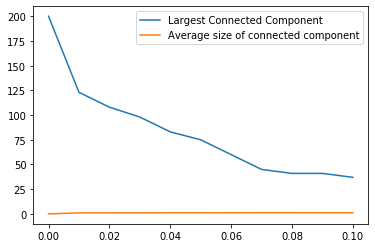

In [10]:
plot_results(diameters, lccs, av_ccs)

## 2. Recoverability measurement

### Recover (preferential addition) and measure the robustness

In [11]:
SF_recovered = pereferential_addition(SF_attack_1, fraction_recovery)
print_robustness(SF_recovered)

Diameter: 6.303303303303303
Size of Largest Connected Component: 37
Average isolated connected component size: 1.2357723577235773


In [12]:
diameters = []
lccs = []
av_ccs = []

# Measure the robustness before the attack
diameters.append(get_diameter(SF_attack_1))
lccs.append(get_LCC_size(SF_attack_1))
av_ccs.append(av_cc_size(SF_attack_1))

# Make a recovery
SF_recovered = SF_attack_1
for i in range(num_experiments):
    SF_recovered = pereferential_addition(SF_recovered, fraction_recovery)
    diameters.append(get_diameter(SF_recovered))
    lccs.append(get_LCC_size(SF_recovered))
    av_ccs.append(av_cc_size(SF_recovered))
fractions = np.arange(0, fraction_recovery*(num_experiments+1), fraction_recovery) #only used for plotting
    
print_robustness(SF_recovered)


Diameter: 7.809523809523809
Size of Largest Connected Component: 63
Average isolated connected component size: 2.3333333333333335


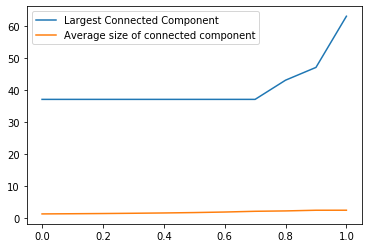

In [13]:
plot_results(diameters, lccs, av_ccs)

## 3. Robustness measurement after recovery 

### Perform attack again and measure the robustness

In [15]:
# plot_results(diameters, lccs, av_ccs) = targeted_attack(SF_recovered, fraction_attack)
# print_robustness(SF_attack_2)

In [16]:
diameters = []
lccs = []
av_ccs = []

# Measure the robustness before the attack
diameters.append(get_diameter(SF_recovered))
lccs.append(get_LCC_size(SF_recovered))
av_ccs.append(av_cc_size(SF_recovered))

# Make an attack
SF_attack_2 = SF_recovered
for i in range(num_experiments):
    SF_attack_2 = targeted_attack(SF_attack_2, fraction_attack)
    diameters.append(get_diameter(SF_attack_2))
    lccs.append(get_LCC_size(SF_attack_2))
    av_ccs.append(av_cc_size(SF_attack_2))
fractions = np.arange(0, fraction_attack*(num_experiments+1), fraction_attack) #only used for plotting

print_robustness(SF_attack_2)

Diameter: 5.0
Size of Largest Connected Component: 14
Average isolated connected component size: 2.357142857142857


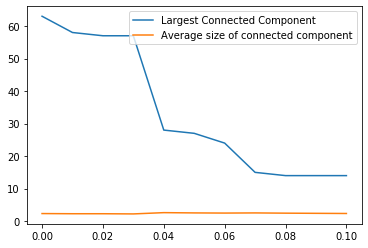

In [17]:
plot_results(diameters, lccs, av_ccs)